VESTAAAAAAAAAAAAAAAAAAAA's cells

In [1]:
import pyFAI
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import fabio
from pyFAI.gui import jupyter
import silx
import pygix
import math
import pandas as pd

print("Using pyFAI version",pyFAI.version)
%matplotlib inline
%pylab inline

#check for changes
display('hello')

ERROR:pygix.transform:Unable to import pyFAI.ocl_azim_csr: cannot import name 'ocl_azim_csr' from 'pyFAI' (C:\Users\19412\anaconda3\lib\site-packages\pyFAI\__init__.py)
ERROR:pygix.transform:Unable to import pyFAI.ocl_azim_lut for: cannot import name 'ocl_azim_lut' from 'pyFAI' (C:\Users\19412\anaconda3\lib\site-packages\pyFAI\__init__.py)
ERROR:pygix.transform:Unable to import pyFAI.ocl_sort for: cannot import name 'ocl_sort' from 'pyFAI' (C:\Users\19412\anaconda3\lib\site-packages\pyFAI\__init__.py)


Using pyFAI version 0.19.0
Populating the interactive namespace from numpy and matplotlib


'hello'

Use anaconda prompt to run "pyFAI-calib2" and follow the documentation to create a .poni file for the detector and calibrant

Use anaconda prompt to run "pyFAI-drawmask filename.tif" and follow the documentation to create a .edf mask file for the image you are analyzing

<AxesSubplot:title={'center':'FASnI3'}>

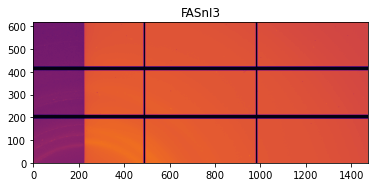

In [81]:
##### LOADING IMAGES #####
path='C:\\Users\\19412\\Downloads\\309859_White.tar\\309859_White\\309859_White\\900KW\\'

### converting tif to edf ###
img = fabio.open(path+'KW_K1_ai0.2_16.1keV_wa0020_sdd2.0m_bpm2.782_000001_WAXS.tif')
img.convert("edf").save("x.edf")

# darkimg = fabio.open('siwafer.tif')
# darkimg.convert("edf").save("siwafer.edf")

### loading image ###
img = fabio.open('x.edf').data
# mask = fabio.open('c60_2-mask.edf').data
# dark = fabio.open('siwafer.edf').data
jupyter.display(img,label = "FASnI3")

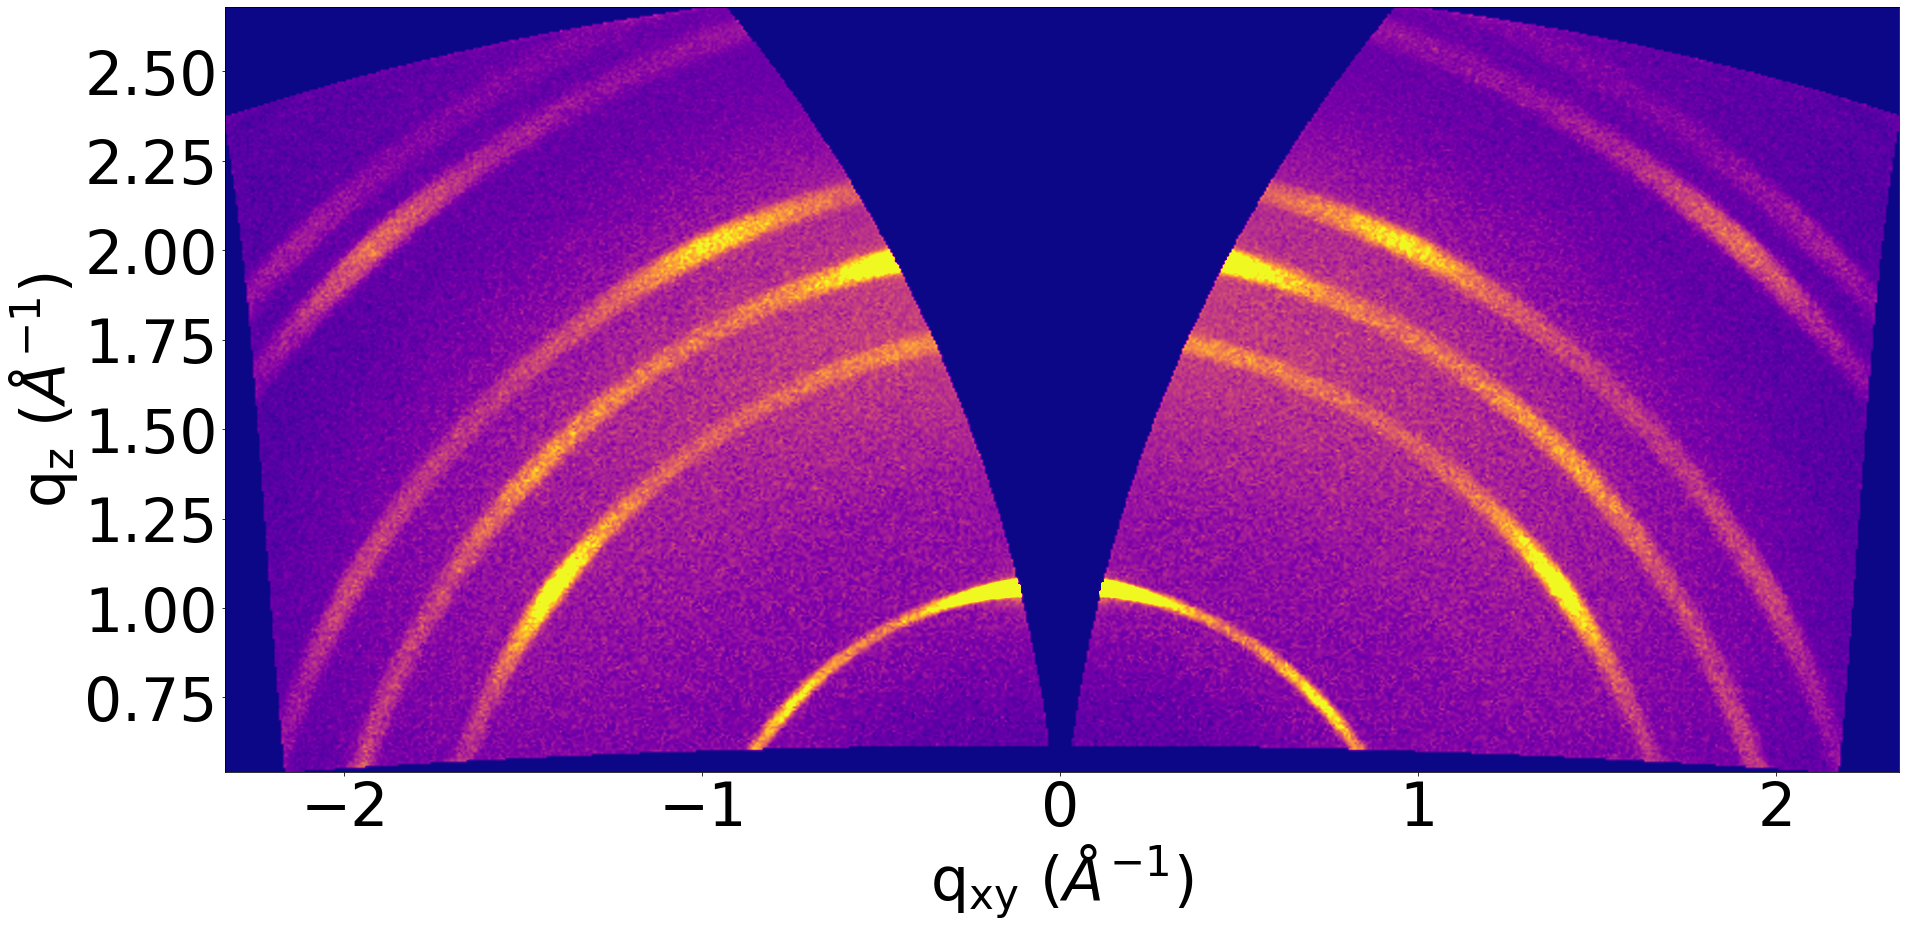

In [74]:
##### CONVERSION TO RECIPROCAL SPACE #####
from pyFAI.calibrant import get_calibrant
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator

pg = pygix.Transform()

pg.load("C:\\Users\\19412\\Documents\\Research\\Data\\FASnI3\\RigakuAl2O3.poni")
# pg.maskfile = 'c60-mask.edf'
# pg.darkfile = 'siwafer.edf'     # baseline file here

pg.sample_orientation = 3
pg.incident_angle = 1
# pg.tilt_angle = 0

img_rec, qxy, qz = pg.transform_reciprocal(img,
                                           method = "bbox",
                                           unit = "A")

figure(figsize = (30,30))

plt.imshow(img_rec,
           extent=(np.min(qxy),np.max(qxy),np.min(qz),np.max(qz)),
           origin = "lower",
           interpolation='spline16')

plt.xlabel('$\mathregular{q_{xy}}$ ($\AA^{-1}$)', fontsize=60)
plt.xticks(fontsize=60)
plt.ylabel('$\mathregular{q_z}$ ($\AA^{-1}$)',fontsize=60)
plt.yticks(fontsize=60)

plt.set_cmap('plasma')
lb = np.nanpercentile(img_rec,0)
ub = np.nanpercentile(img_rec,99.5)
plt.clim(lb,ub)

# plt.savefig(path+'analysis\\FASnI3_P.tiff',dpi=600)


Detector Detector	 Spline= None	 PixelSize= 1.000e-04, 1.000e-04 m


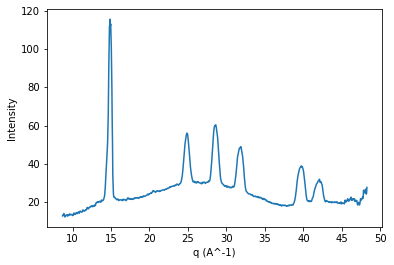

In [49]:
##### 1D INTEGRATION ##### 
import pandas as pd

ai = pyFAI.load("C:\\Users\\19412\\Documents\\Research\\Data\\FASnI3\\RigakuAl2O3.poni")

calibdete = pyFAI.detector_factory(ai.detector); # creates new detector based on calibration settings
print(calibdete) # prints detector information

res = ai.integrate1d(img,
                    1000,   # number of points in the output
                    unit="2th_deg",
#                     unit="q_A^-1",
                    azimuth_range=(-90,0))

##### displaying integration result
tth=res[0]
I=res[1]
plt.plot(tth,I)
plt.xlabel("q (A^-1)")
plt.ylabel("Intensity")

### exporting data to csv
b = np.array(tth)
c = np.array(I)
df=pd.DataFrame({"2theta" : b, "Intensity" : c})
# df.to_csv(path+'analysis\\FASnI3_P_1D.csv',index=False)


[14.878903503906834, 24.891370681249263, 28.61141777480732, 31.856565239400517, 39.73198408640109, 42.06690726214497]


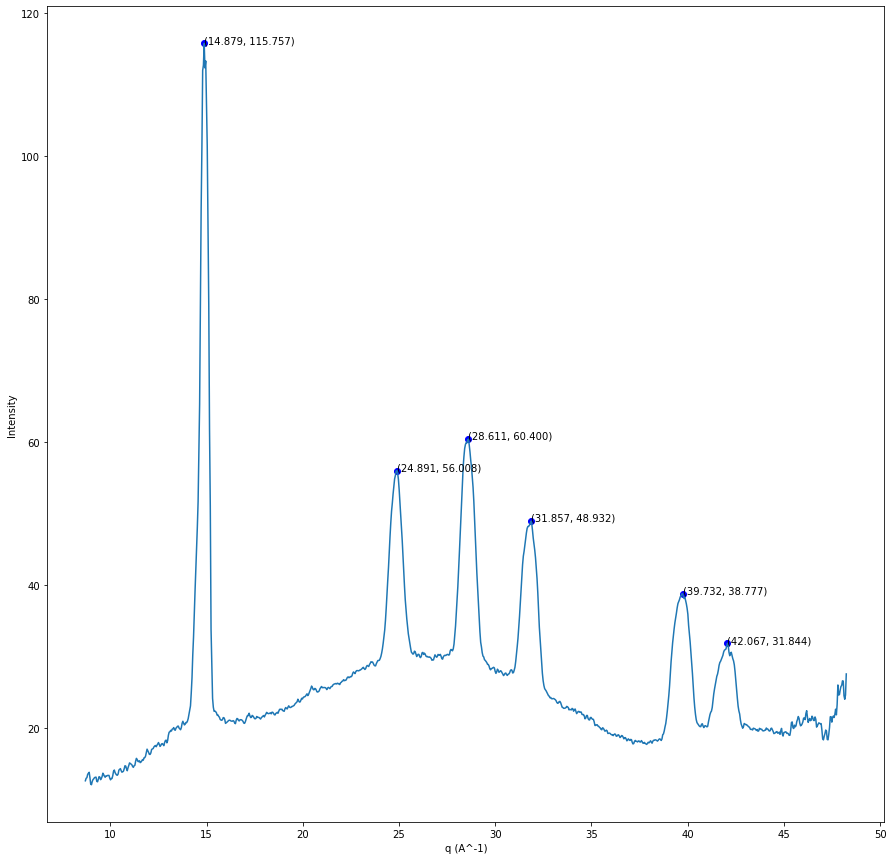

In [50]:
##### PEAK FINDER #####

import scipy as sp
from scipy import signal
import csv

peaks=[]
peaks=sp.signal.find_peaks(I,prominence=10,width=0.5,distance=50)[0]

peaks_tth=[]
for i in range(0,len(peaks)):
    peaks_tth.append(tth[peaks[i]])
print(peaks_tth)

##### displaying peaks
fig = plt.figure()
ax = fig.add_subplot(111)
    
ax.plot(peaks_tth,I[peaks], "ob");
ax.plot(tth,I)
plt.xlabel("q (A^-1)")
plt.ylabel("Intensity")
plt.gcf().set_size_inches(15,15)

for xy in zip(peaks_tth,I[peaks]):
    ax.annotate('(%.3f, %.3f)' %xy, xy=xy, textcoords='data')

##### saving list of peaks in csv
a = np.array(peaks_tth)
aa = np.array(I[peaks])
dfa=pd.DataFrame({"peak_2theta" : a, "peak_intensity" : aa})
# dfa.to_csv("peaks_c60_avg.csv",index=False)

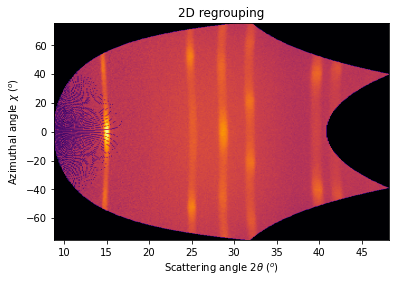

In [52]:
##### CAKING #####

res2d=ai.integrate2d(img,
                    300,    # number of points in radial direction
                    500,    # number of points in azimuthal direction
                    unit="2th_deg",
                    method="cython")     # default method
#                     azimuth_range=(0,90))

# pulling intensity, 2-theta, and azimuthal arrays out
I2, tth2, chi = res2d
for i in range(0,len(chi)):     #changes reference of azimuthal angle to increase clockwise from qx axis
    chi[i]=chi[i]+90
    
# display integration result
jupyter.plot2d(res2d,label="sample 2D regrouping")
# plt.savefig(path+'\\analysis\\P_cake.tiff',dpi=600)

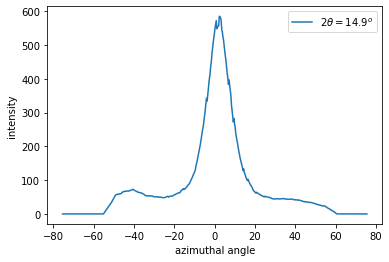

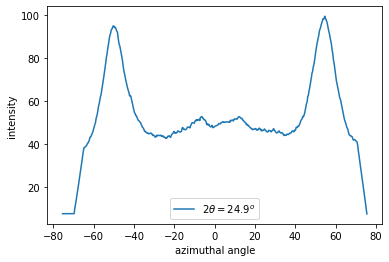

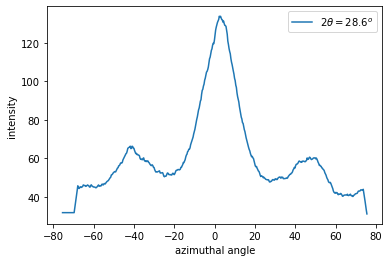

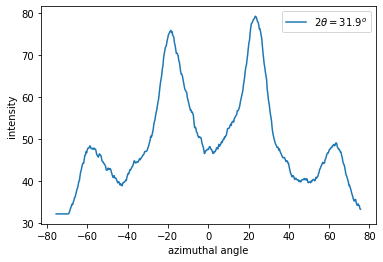

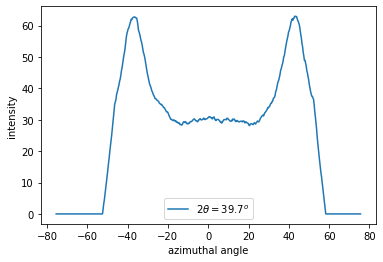

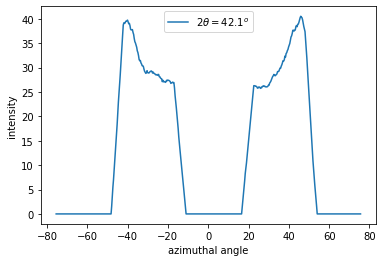

,0,1,2,3,4,5,6
0,-75.459414,0.0,7.410793,31.698766,32.263986,0.0,0.0
1,-75.156772,0.0,7.410793,31.698766,32.263986,0.0,0.0
2,-74.854131,0.0,7.410793,31.698766,32.263986,0.0,0.0
3,-74.551489,0.0,7.410793,31.698766,32.263986,0.0,0.0
4,-74.248848,0.0,7.410793,31.698766,32.263986,0.0,0.0
...,...,...,...,...,...,...,...
495,74.348168,0.0,15.471706,39.583374,34.637973,0.0,0.0
496,74.650809,0.0,13.660999,37.582304,34.303305,0.0,0.0
497,74.953451,0.0,11.760392,35.257055,34.232185,0.0,0.0
498,75.256092,0.0,9.294212,33.061005,33.495473,0.0,0.0


In [75]:
##### RADIAL INTEGRATION #####

# #### SINGLE target
# target = 14.8 # target scattering angle (degrees) SINGLE
# column = np.argmin(abs(tth2-target))     # defines column number (scattering angle) SINGLE

# ## display integration
# fig,ax = plt.subplots()
# # y=I2[:,column]
# y=signal.savgol_filter(I2[:,column],61,3)                            #smoothing
# ax.plot(chi,y,label=r"$2\theta=%.1f^{o}$"%target)
# ax.set_xlabel("azimuthal angle")
# ax.set_ylabel("intensity")
# ax.set_title("radial integration")
# ax.legend()

##### ARRAY of targets
target = peaks_tth      # target angles ARRAY
column=[]
for i in range(0,len(target)):
    column.append(np.argmin(abs(tth2-target[i])))
nrows=len(peaks_tth)

fig, ax = plt.subplots()

dfa=pd.DataFrame(pd.Series(chi))
# dfa=pd.DataFrame({"chi" : a, "peak_intensity" : aa})

for i in range(0,len(target)):
    I2m=pd.Series(I2[:,column[i]])
    y=I2m.iloc[:].rolling(window=20).mean().fillna(method='bfill')      #smoothing
    plt.plot(chi,y,label=r"$2\theta=%.1f^{o}$"%target[i])
    plt.xlabel("azimuthal angle")
    plt.ylabel("intensity")
    plt.legend()
    plt.show()
    dfa=pd.concat([dfa,y],axis=1,ignore_index=True)
    
##### saving chi-plots
display(dfa)
#     dfa.to_csv(path+'P_'+str(i)+'_'+str(round(target[i],2))+'_chiplot.csv',index=False)

f =  0.014684696869141423  at scattering angle  10.255
values of interest: 
   f =  0.9949697381318208  for edge-on
   f =  -0.5  for face-on
   f =  0  for random
 f' =  0.014758938193149235  normalized


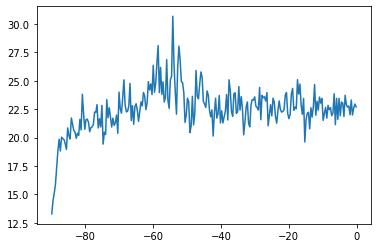

In [8]:
##### HERMAN ORIENTATION PARAMETER #####

import scipy as s
from scipy import integrate

num=[] # integrand in numerator
den=[] # integrand in denominator
I2m=I2[:,column] # takes the value at the [column] position from every array (azimuthal angle) in I22 arrays
chi_rad=[] # chi in radians

##### removing 0-valued pixels for integration
new_chi=[]
new_I2m=[]

for i in range(-int(len(chi)/2),0):
    if (I2m[i] > 0):
        new_chi.append(chi[i])
        new_I2m.append(I2m[i])

##### populating numerator and denominator integrand arrays and chi-in-radians array
for i in range(0,len(new_chi)):
    chi_rad.append(new_chi[i]*math.pi/180)
for i in range(0,len(chi_rad)):
    num.append(new_I2m[i]*(math.cos(chi_rad[i]))**2*math.sin(chi_rad[i]))
    den.append(new_I2m[i]*math.sin(chi_rad[i]))

plt.plot(new_chi,new_I2m)

##### finding the baseline for no preferential orientation
anum= lambda x: math.cos(x)**2*math.sin(x)
aden= lambda x: math.sin(x)

##### trapezoidal integration
numint=s.integrate.trapz(num,chi_rad)
denint=s.integrate.trapz(den,chi_rad)

anumint=s.integrate.quad(anum,chi_rad[0],chi_rad[len(chi_rad)-1])
adenint=s.integrate.quad(aden,chi_rad[0],chi_rad[len(chi_rad)-1])
a = anumint[0]/adenint[0]
cos2_avg=numint/denint

##### orientation parameter
f=0.5*((1/a)*cos2_avg-1)
print("f = ",f," at scattering angle ",target)
print("values of interest: ")
e_on=((1/a)-1)/2
print("   f = ", e_on, " for edge-on")
print("   f = ", -1/2, " for face-on")
print("   f = ", 0, " for random")
print(" f' = ", f/e_on, " normalized")